In [74]:
%matplotlib inline

from __future__ import division

from pdb import set_trace as BP

import os

import numpy as np
import tables
import matplotlib.pyplot as plt



# Select an experiment and load it

This will iterate over all experiments in the ```output/``` directory and select the most recent one that matches the pattern. 

In [75]:
#fname = 'output/learning-and-inference-param-bars-gsc.py.2019-03-26+15:25//result.h5'
fname = None

if fname is None:
    found = False
    count = -1
    pattern = "learning-and-inference"
    matching_experiments = ['output/' + dirname for dirname in os.listdir("output") if pattern in dirname]
    matching_experiments = sorted(matching_experiments, key=os.path.getmtime)
    
    print("Found %d experiments matching pattern" % len(matching_experiments))    
    
    while not found:
        try:    
            selected_experiment = matching_experiments[count]
            fname = os.path.join(selected_experiment, "result.h5")
            h5 = tables.open_file(fname)
            found = True
        except:
            count -= 1
else:
    h5 = tables.open_file(fname)

node_names = h5.root.__members__    
print('Loading %s' % fname)

N_plot = 10

test_data = h5.root.test_data[:][-1]
if test_data.shape[0] >= N_plot:
    test_data = test_data[:N_plot,:]
else:
    N_plot = test_data.shape[0]
    
Hprime_start, gamma_start = h5.root.Hprime_start[:][-1], h5.root.gamma_start[:][-1]
D, H = h5.root.W[:][-1].shape
D1 = int(np.sqrt(D))
clim_abs = np.max(np.abs(np.array([np.min(test_data), np.max(test_data)])))
clim = [-clim_abs, clim_abs]
        


data_points = {}
n, k = 0, 0
lookup = True
    
while lookup:        
    if (not any(['test_n%i' % n in s for s in node_names])) or (n >= N_plot):
        break

    results = {}
    results['y'] = test_data[n,:]
    results['Hprime'] = int(h5.get_node('/test_n%i_Hprime' % n)[:][-1])    
    results['gamma'] = int(h5.get_node('/test_n%i_gamma' % n)[:][-1])
    topK = int([s for s in node_names if 'test_n%i_p_top' % n in s][0].split('top')[1])
    results['topK'] = topK
    results['p_topK'] = h5.get_node('/test_n%i_p_top%i' % (n,topK))[:][-1]
    results['comps'] = {}
    for k in range(topK):
        results['comps']['top%i' % k] = h5.get_node('/test_n%i_comps_top%i' % (n,k))[:][-1]
    results['comps']['gt'] = h5.get_node('/test_n%i_comps_gt' % n)[:][-1]
    data_points['%i' % n] = results            
        
    n += 1

print('Loaded results for %i test data points' % n)

h5.close()

Found 94 experiments matching pattern
Loading output/learning-and-inference-param-bars-mca.py.2019-03-26+18:50/result.h5
Loaded results for 10 test data points


# Draw visualization

This will visualize the output of `bars-learning-and-inference.py`.

Hprime_start = 5
gamma_start = 3



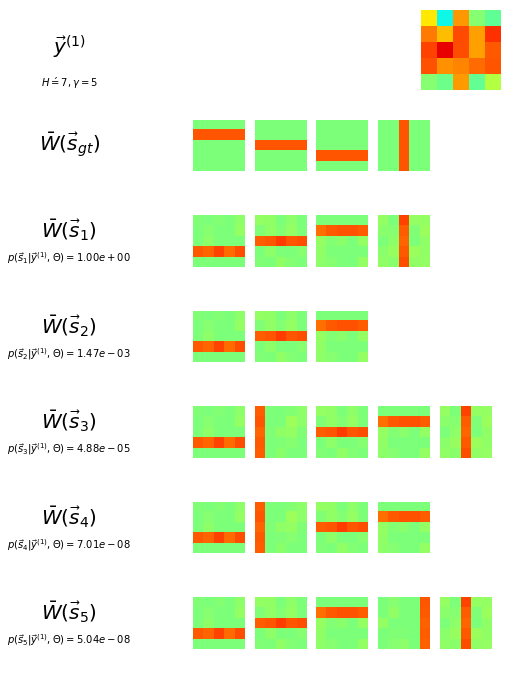

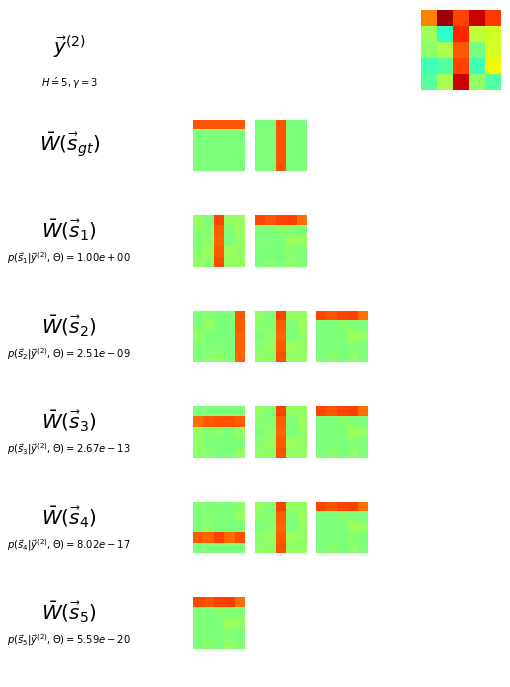

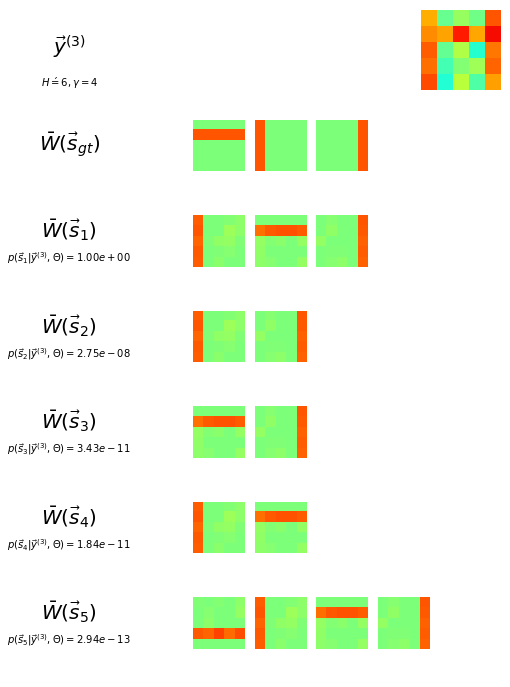

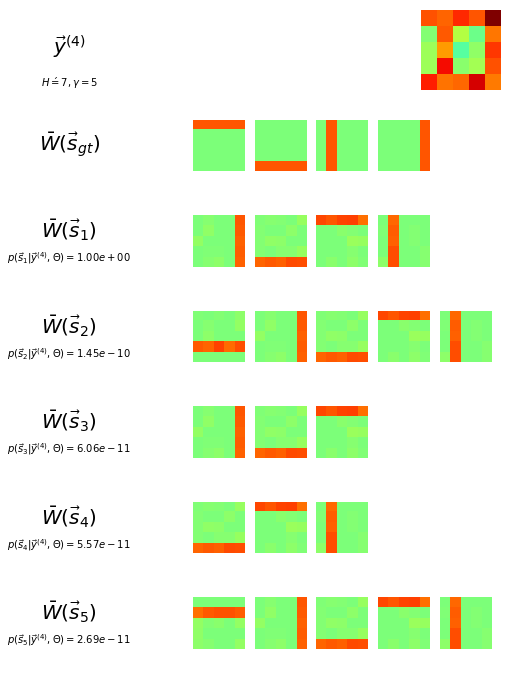

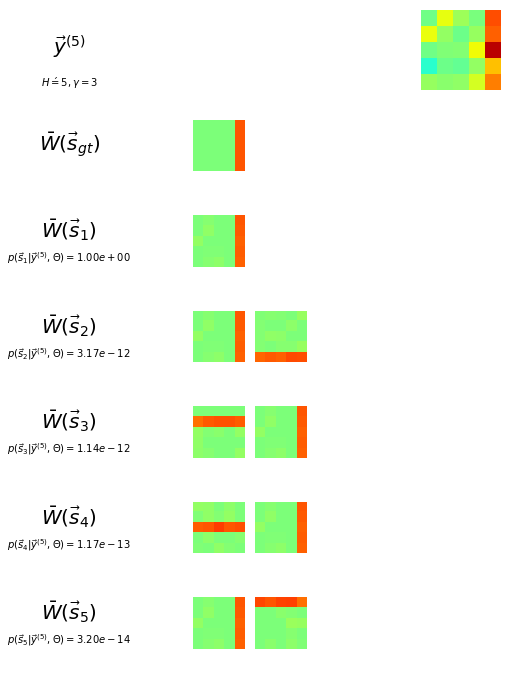

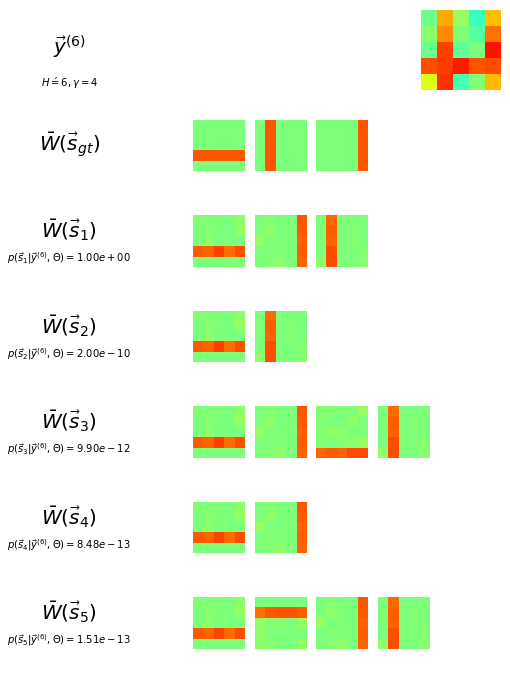

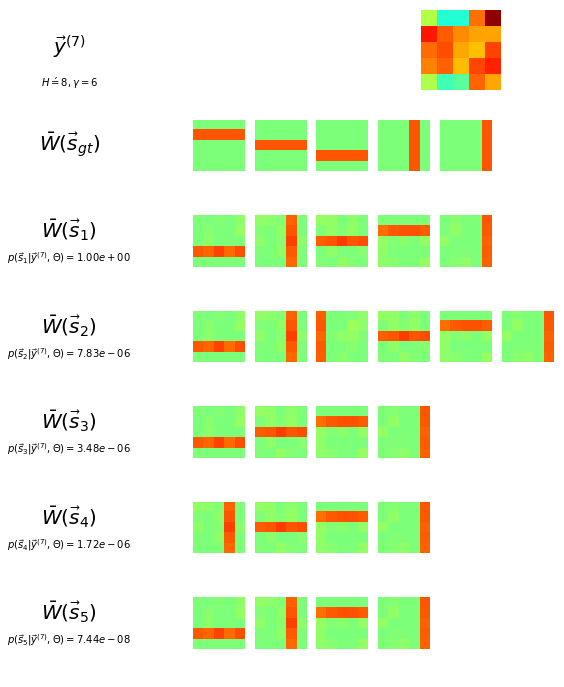

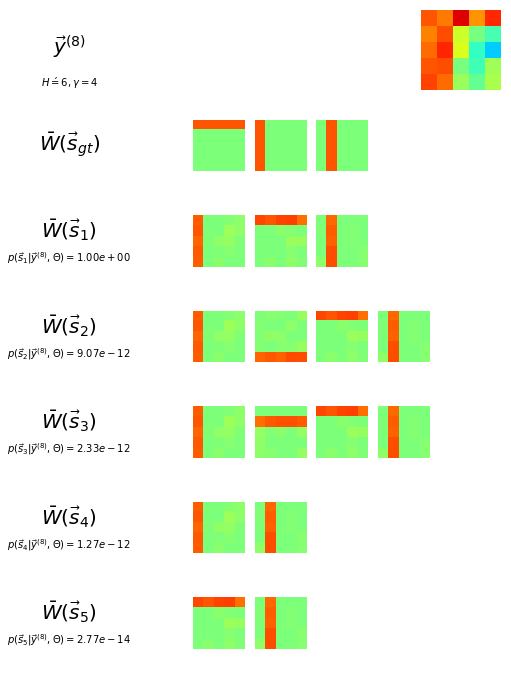

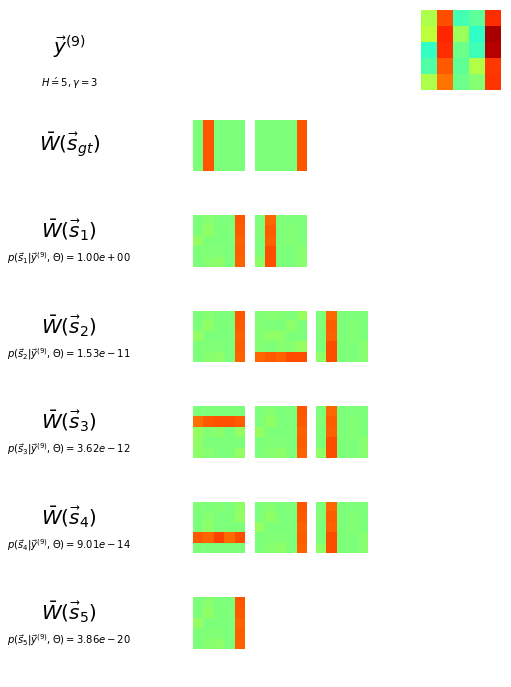

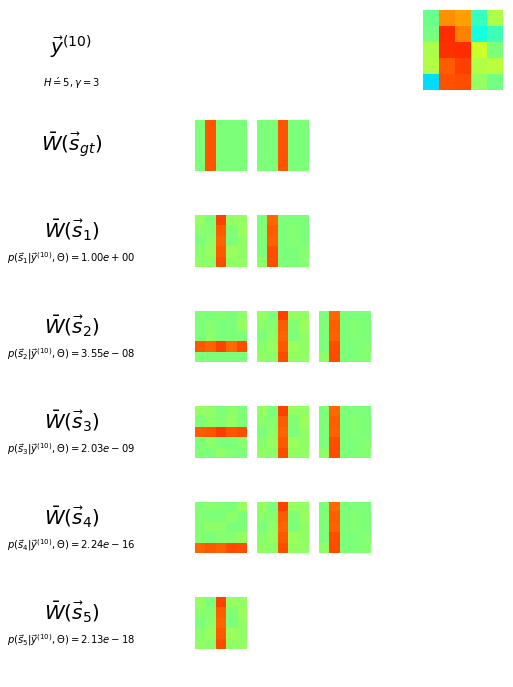

In [76]:
print('Hprime_start = %i' % Hprime_start)
print('gamma_start = %i' % gamma_start)
print()

figs = {}
figsize = [12.,12.]
fontsize_large = 20
fontsize_small = 10
fparams = {'clim' : clim, 'interpolation': 'nearest', 'cmap' : 'jet'}
tparams = {'fontsize' : fontsize_large, 'horizontalalignment' : 'center'}
for key in data_points:
    
    figs[key] = {}
    
    n = int(key)
    topK = int(data_points[key]['topK'])
    plt.figure(figsize=figsize)
    figs[key]['ax_y'] = plt.subplot2grid((topK+2,H+2), (0,2), colspan=H)
    figs[key]['ax_y'].imshow(data_points[key]['y'].reshape(D1,D1),**fparams)
    plt.axis('off')
    
    figs[key]['axyl'] = plt.subplot2grid((topK+2,H+2), (0,0))
    figs[key]['axyl'].text(0., .45, r'$\vec{y}^{(%i)}$' % (n+1), **tparams)
    tparams['fontsize'] = fontsize_small    
    figs[key]['axyl'].text(0., .05, r'$H\'=%i, \gamma=%i$' % (data_points[key]['Hprime'],
                                                              data_points[key]['gamma']),
                           **tparams)
    tparams['fontsize'] = fontsize_large
    
    plt.axis('off')
    
    for k in range(topK):
        comps = data_points[key]['comps']['top%i' % k]
        comps_gt = data_points[key]['comps']['gt']
        if type(comps) == np.int64:
            if comps == 0:
                n_comps = 0
        else:            
            n_comps = comps.shape[1]
        if type(comps_gt) == np.int64:
            if comps_gt == 0:
                n_comps_gt = 0
        else:
            n_comps_gt = comps_gt.shape[1]
        
        figs[key]['ax_Wbargtl'] = plt.subplot2grid((topK+2,H+2), (1,0))
        if 'gsc' in fname:
            tmp = r'$\bar{W}(\vec{s}_{gt},\vec{z}_{gt})$'
        else:
            tmp = r'$\bar{W}(\vec{s}_{gt})$'
        figs[key]['ax_Wbargtl'].text(0,.45, tmp, **tparams)
        plt.axis('off')
        
        figs[key]['ax%il' % k] = plt.subplot2grid((topK+2,H+2), (k+2,0))
        figs[key]['ax%il' % k].text(0.,.55, r'$\bar{W}(\vec{s}_%i)$' % (k+1), **tparams)
        tparams['fontsize'] = fontsize_small
        figs[key]['ax%il' % k].text(0.,.25, r'$p(\vec{s}_%i\vert\vec{y}^{(%i)},'
                                    '\Theta)=%.2e$' % (k+1,n+1,data_points[key]['p_topK'][k]),
                                    **tparams)
        tparams['fontsize'] = fontsize_large
        plt.axis('off')
        
        for h in range(H):
            if k == 0 and h < n_comps_gt:                
                figs[key]['ax_Wbargt'] = plt.subplot2grid((topK+2,H+1), (k+1,h+2))
                figs[key]['ax_Wbargt'].imshow(comps_gt[:,h].reshape(D1,D1),**fparams)
                plt.axis('off')
            if h < n_comps:                    
                figs[key]['ax%i%i' % (k,h)] = plt.subplot2grid((topK+2,H+1), (k+2,h+2))
                figs[key]['ax%i%i' % (k,h)].imshow(comps[:,h].reshape(D1,D1),**fparams)
                plt.axis('off')

plt.show()